# Preparation

In [1]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
import joblib
from pyspark.mllib.tree import RandomForest
%run functions.py
from xgboost import XGBClassifier
# Xgboost

In [2]:
# Path to initial data tables
genpath = 'init_data/'
organisms = ['arabidopsis', 'pisum', 'oryza', 'cicer']
table = 'feature_table.csv'

path = [genpath + org + '_' + table for org in organisms]

In [3]:
# Make directories for saving classifiers
cdir, sdir, ldir = 'classifiers', 'all', 'best'

cdir = make_dir_if_not_exists('./', cdir)
sdir = make_dir_if_not_exists(cdir, sdir)
ldir = make_dir_if_not_exists(cdir, ldir)

# Import Datasets

In [4]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
import scipy

In [5]:
# Import A. thaliana data
subs_a, Xa, ya, pph2_prob_a, pph2_pred_a = get_data(path[0])

# Import P. sativum data
subs_p, Xp, yp, pph2_prob_p, pph2_pred_p = get_data(path[1])

# Import O. sativa data
subs_o, Xo, yo, pph2_prob_o, pph2_pred_o = get_data(path[2])

# Import C. arietinum data
subs_c, Xc, _,  pph2_prob_c, pph2_pred_c = get_data(path[3], labels=False)

def delete_data(X):
    data_inds = [4, 8, 9] # Blo62, helix, strand
    
    X.drop(labels=X.columns[data_inds], inplace = True, axis = 1)

delete_data(Xa)
delete_data(Xp)
delete_data(Xo)
delete_data(Xc)

In [6]:
# Function that scales data relative to A. thaliana
std_data = lambda x: (x - Xa.min()) / (Xa.max() - Xa.min())

stdXa, stdXp, stdXo, stdXc = std_data(Xa), std_data(Xp), std_data(Xo), std_data(Xc)

In [7]:
# Obtain train and test data
# Fix random state in order to get the same separation after running the line below
Xa_train, Xa_test, ya_train, ya_test = train_test_split(stdXa, ya, test_size=1000, random_state=0)

# Computation of Weights

In [8]:
mean_p, mean_o = stdXp.mean(axis=0), stdXo.mean(axis=0)

# Weights calculations for P. sativum
Wp = [np.exp(-(np.linalg.norm(row - mean_p)) ** 2) for _, row in Xa_train.iterrows()]
Wp = np.array(Wp)

# Weights calculations for O. sativa
Wo = [np.exp(-(np.linalg.norm(row - mean_o)) ** 2) for _, row in Xa_train.iterrows()]
Wo = np.array(Wo)

# Grid Search for Hyperparameters

In [9]:
from catboost import CatBoostClassifier
# Preparation for grid search
descriptions = ['Random Forest']
classifiers = [RandomForestClassifier()]

# Make the grid; each dict with hyperparameters corresponds to its classifier
parameters = [{'n_estimators': list(range(100, 600, 20))}]
# Search hyperparameters for all classifiers
best_params = []
for desc, ml, pars in zip(descriptions, classifiers, parameters):
    
    clf = GridSearchCV(ml, pars, cv=5, scoring='accuracy')
    clf.fit(Xa_train, ya_train)
    
    best_params.append(clf.best_params_)
    print("Best parameters for {}: {}".format(desc, best_params[-1]))

Best parameters for Random Forest: {'n_estimators': 180}


# Classifiers' Training

In [10]:
n_repeats = 100
accs_wo, accs_wi, accs_Wo = [0,0], [0,0], [0, 0]

In [11]:
best_classifiers_wo, best_classifiers_Wi, best_classifiers_Wo = [0, 0], [0, 0], [0, 0]

for i in range(n_repeats):
    
    print('{:03} / {:03}'.format(i + 1, n_repeats))
    
    # Fit classifers with the best hyperparameters and without weights
    fitted_wo = [RandomForestClassifier(**best_params[0]).fit(Xa_train, ya_train)]

    # Fit classifers with both the best hyperparameters and weights obtained for P. sativum data
    fitted_wi_Wp = [RandomForestClassifier(**best_params[0]).fit(Xa_train, ya_train, sample_weight=Wp)]
    
    # Fit classifers with both the best hyperparameters and weights obtained for O. sativa data
    fitted_wi_Wo = [RandomForestClassifier(**best_params[0]).fit(Xa_train, ya_train, sample_weight=Wo)]
    
    for di, d in enumerate(descriptions):
        # Export classifers into files
        c_wo, c_p, c_o = fitted_wo[di], fitted_wi_Wp[di], fitted_wi_Wo[di]
        tmp_acc = sum([accuracy_score(ya_test, c_wo.predict(Xa_test)),
                                accuracy_score(yp, c_wo.predict(stdXp)),
                                accuracy_score(yo, c_wo.predict(stdXo))])
        
        if (tmp_acc > accs_wo[di]):
            accs_wo[di] = tmp_acc
            best_classifiers_wo[di] = c_wo
        
        tmp_acc = accuracy_score(yp, c_p.predict(stdXp))
                            
        if (tmp_acc > accs_wi[di]):
            accs_wi[di] = tmp_acc
            best_classifiers_Wi[di] = c_p
        
        tmp_acc = accuracy_score(yo, c_o.predict(stdXo))
        
        if (tmp_acc > accs_Wo[di]):
            accs_Wo[di] = tmp_acc
            best_classifiers_Wo[di] = c_o

001 / 100
002 / 100
003 / 100
004 / 100
005 / 100
006 / 100
007 / 100
008 / 100
009 / 100
010 / 100
011 / 100
012 / 100
013 / 100
014 / 100
015 / 100
016 / 100
017 / 100
018 / 100
019 / 100
020 / 100
021 / 100
022 / 100
023 / 100
024 / 100
025 / 100
026 / 100
027 / 100
028 / 100
029 / 100
030 / 100
031 / 100
032 / 100
033 / 100
034 / 100
035 / 100
036 / 100
037 / 100
038 / 100
039 / 100
040 / 100
041 / 100
042 / 100
043 / 100
044 / 100
045 / 100
046 / 100
047 / 100
048 / 100
049 / 100
050 / 100
051 / 100
052 / 100
053 / 100
054 / 100
055 / 100
056 / 100
057 / 100
058 / 100
059 / 100
060 / 100
061 / 100
062 / 100
063 / 100
064 / 100
065 / 100
066 / 100
067 / 100
068 / 100
069 / 100
070 / 100
071 / 100
072 / 100
073 / 100
074 / 100
075 / 100
076 / 100
077 / 100
078 / 100
079 / 100
080 / 100
081 / 100
082 / 100
083 / 100
084 / 100
085 / 100
086 / 100
087 / 100
088 / 100
089 / 100
090 / 100
091 / 100
092 / 100
093 / 100
094 / 100
095 / 100
096 / 100
097 / 100
098 / 100
099 / 100
100 / 100


In [12]:
rdir = make_dir_if_not_exists(ldir, "mybest_classifiers")



for di, d in enumerate(descriptions):
    try:
        c_wo = joblib.load(rdir + d + '_wout_weights.pkl') 
    except:
        c_wo = best_classifiers_wo[di]
    try:
        c_p = joblib.load(rdir + d + '_with_weights_for_pisum.pkl')
    except:
        c_p = best_classifiers_Wi[di]
    try:
        c_o = joblib.load(rdir + d + '_with_weights_for_oryza.pkl')
    except:
        c_o = best_classifiers_Wo[di]
    
    tmp_acc = sum([accuracy_score(ya_test, c_wo.predict(Xa_test)),
                                accuracy_score(yp, c_wo.predict(stdXp)),
                                accuracy_score(yo, c_wo.predict(stdXo))]) / 3
    
    if (tmp_acc <= accs_wo[di]):
        joblib.dump(best_classifiers_wo[di], rdir + d + '_wout_weights.pkl') 
        
    tmp_acc = accuracy_score(yp, c_p.predict(stdXp))
                            
    if (tmp_acc <= accs_wi[di]):
        joblib.dump(best_classifiers_Wi[di], rdir + d + '_with_weights_for_pisum.pkl')
        
    tmp_acc = accuracy_score(yo, c_o.predict(stdXo))
        
    if (tmp_acc <= accs_Wo[di]):
        joblib.dump(best_classifiers_Wo[di], rdir + d + '_with_weights_for_oryza.pkl')

# Import of the Best Classifiers

In [34]:
rdir = make_dir_if_not_exists(ldir, "mybest_classifiers_total")

In [35]:
# Import the best classifers fitted without weights 
lsvm_wo = joblib.load(ldir + 'Linear_SVM_wout_weights.pkl')
gsvm_wo = joblib.load(ldir + 'Gaussian_SVM_wout_weights.pkl')
rf_wo   = joblib.load(rdir + 'Random Forest_wout_weights.pkl')

# Import the best classifers fitted with weights obtained for O. sativa data
lsvm_o = joblib.load(ldir + 'Linear_SVM_with_weights_for_oryza.pkl')
gsvm_o = joblib.load(ldir + 'Gaussian_SVM_with_weights_for_oryza.pkl')
rf_o   = joblib.load(rdir + 'Random Forest_with_weights_for_oryza.pkl')

# Import the best classifers fitted with weights obtained for P. sativum data
lsvm_p = joblib.load(ldir + 'Linear_SVM_with_weights_for_pisum.pkl')
gsvm_p = joblib.load(ldir + 'Gaussian_SVM_with_weights_for_pisum.pkl')
rf_p   = joblib.load(rdir + 'Random Forest_with_weights_for_pisum.pkl')


# Feature importance
## Random forest features analyzis
To find feature importance we will use default model without weights and default train/test data.

### Feature importance based on mean decrease in impurity.
https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

<AxesSubplot:>

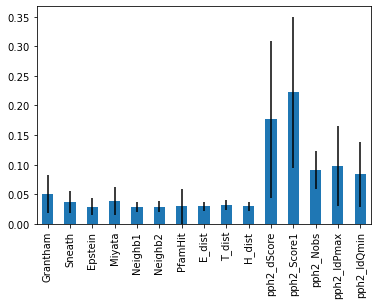

In [36]:
importances=rf_wo.feature_importances_
forest_importances = pd.Series(importances, index=Xa.columns)
std = np.std([tree.feature_importances_ for tree in rf_wo.estimators_], axis=0)
# посмотреть по какому критерию проводится анализ важности признака
# провести дополнительный анализ признаков по другим шкалам
forest_importances.plot.bar(yerr=std)

### Feature importance based on feature permutation
https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [37]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf_wo, Xa_test, ya_test, n_repeats=50, random_state=42, n_jobs=2
)

<AxesSubplot:>

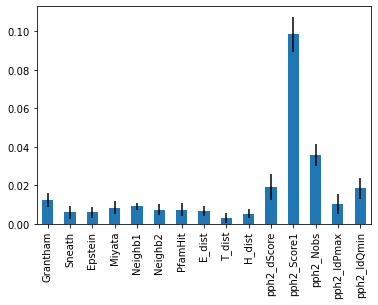

In [38]:
forest_importances = pd.Series(result.importances_mean, index=Xa.columns)

forest_importances.plot.bar(yerr=result.importances_std)

### Feature Importance Computed with SHAP Values
https://mljar.com/blog/feature-importance-in-random-forest/

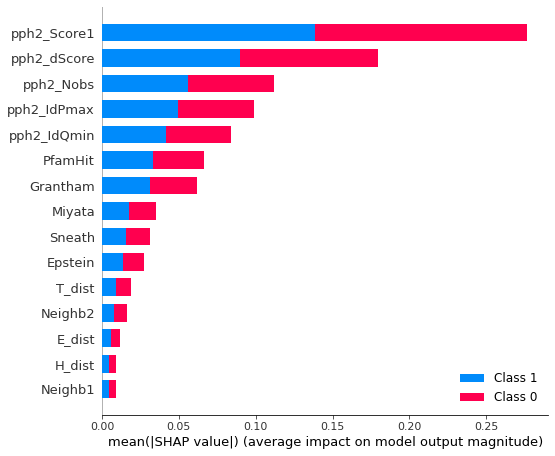

In [39]:
import shap

explainer = shap.TreeExplainer(rf_wo)
shap_values = explainer.shap_values(Xa_test)

shap.summary_plot(shap_values, Xa_test, plot_type="bar")

## Feature importance TL

In [40]:
rf_o = best_classifiers_Wo[0]
rf_p = best_classifiers_Wi[0]

<AxesSubplot:>

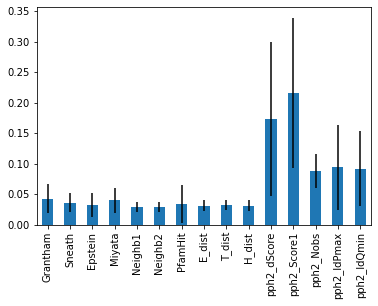

In [41]:
importances=rf_o.feature_importances_
forest_importances = pd.Series(importances, index=Xo.columns)
std = np.std([tree.feature_importances_ for tree in rf_o.estimators_], axis=0)
# посмотреть по какому критерию проводится анализ важности признака
# провести дополнительный анализ признаков по другим шкалам
forest_importances.plot.bar(yerr=std)

<AxesSubplot:>

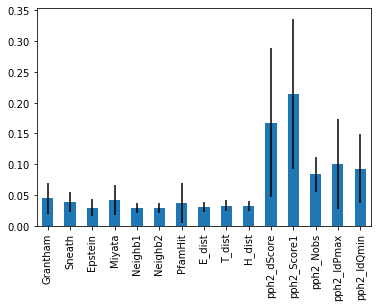

In [42]:
importances=rf_p.feature_importances_
forest_importances = pd.Series(importances, index=Xp.columns)
std = np.std([tree.feature_importances_ for tree in rf_p.estimators_], axis=0)
# посмотреть по какому критерию проводится анализ важности признака
# провести дополнительный анализ признаков по другим шкалам
forest_importances.plot.bar(yerr=std)

In [43]:
lsvm_wo = LinearSVC().fit(Xa_train, ya_train)
gsvm_wo = SVC().fit(Xa_train, ya_train)
lsvm_o = LinearSVC().fit(Xa_train, ya_train)
gsvm_o = SVC().fit(Xa_train, ya_train)
lsvm_p = LinearSVC().fit(Xa_train, ya_train)
gsvm_p = SVC().fit(Xa_train, ya_train)

In [44]:
clfs_a = [lsvm_wo, gsvm_wo, rf_wo]
clfs_o = [lsvm_wo, gsvm_wo, rf_wo, lsvm_o, gsvm_o, rf_o]
clfs_p = [lsvm_wo, gsvm_wo, rf_wo, lsvm_p, gsvm_p, rf_p]

# Resulting Tables

In [45]:
# A. thaliana table
tab_a = result_table(subs_a, Xa, stdXa, ya, pph2_prob_a, pph2_pred_a, clfs_a, Xa_test)
tab_a.to_csv(sdir + 'table_arabidopsis.tsv', sep='\t', index=False)

# O. sativa table
tab_o = result_table(subs_o, Xo, stdXo, yo, pph2_prob_o, pph2_pred_o, clfs_o)

# P. sativum table
tab_p = result_table(subs_p, Xp, stdXp, yp, pph2_prob_p, pph2_pred_p, clfs_p)

# ROC-curves and Metrics for A. thaliana

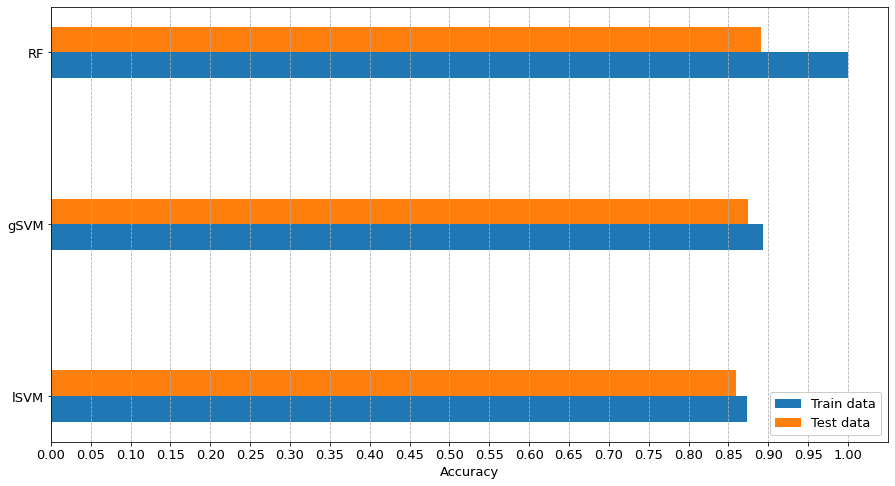

,Train data,Test data
lSVM,0.874,0.860
gSVM,0.893,0.874
RF,1.000,0.891


In [46]:
# Overall information showing the absence of overfitting
accs = arab_plot_accs(Xa_train, Xa_test, ya_train, ya_test, clfs_a)
accs

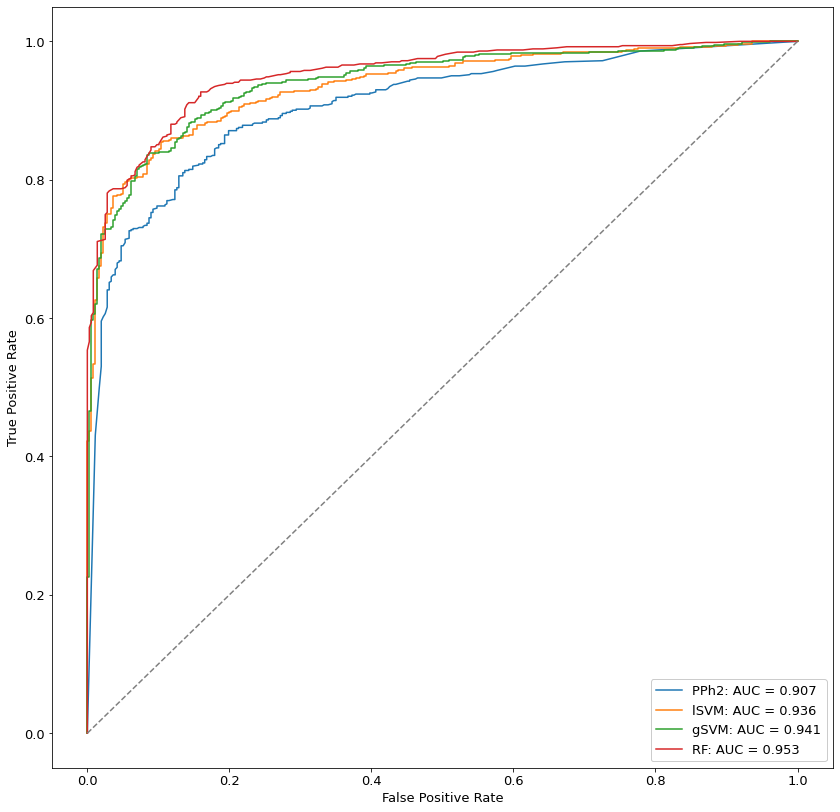

In [47]:
# ROC-curves for all classifiers related with A. thaliana
roc_curves(tab_a, is_arab=True)

In [48]:
# Confusion matrixes for all classifiers related with A. thaliana
mets_mats_arab(tab_a)[0]

PPh2                        lSVM                \
           Predicted_Neu Predicted_Del Predicted_Neu Predicted_Del   
Actual_Neu           293            64           291            66   
Actual_Del           100           543            74           569   

                    gSVM                          RF                
           Predicted_Neu Predicted_Del Predicted_Neu Predicted_Del  
Actual_Neu           298            59           307            50  
Actual_Del            67           576            59           584

In [49]:
# Table with metrics for all classifiers related with A. thaliana
mets_mats_arab(tab_a)[1] 

,PPh2,lSVM,gSVM,RF
Accuracy,0.836,0.860,0.874,0.891
FPR,0.179,0.185,0.165,0.140
FNR,0.156,0.115,0.104,0.092
Sensetivity,0.844,0.885,0.896,0.908
Specificity,0.821,0.815,0.835,0.860
AUC,0.907,0.936,0.941,0.953


# ROC-curves and Metrics for O. sativa

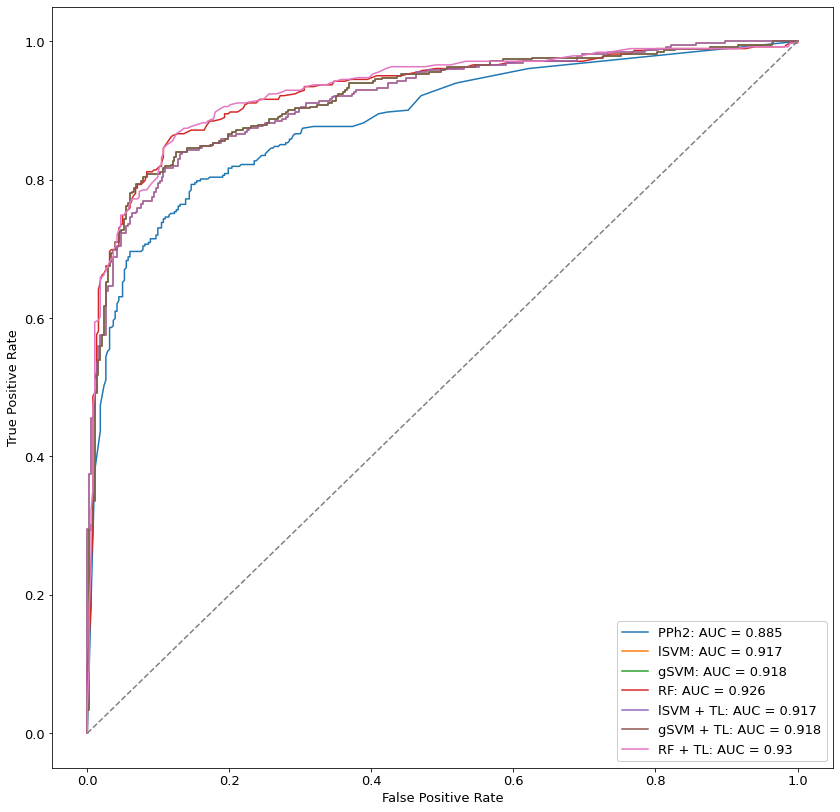

In [50]:
# ROC-curves for all classifiers related with O. sativa
roc_curves(tab_o, is_arab=False)

In [51]:
# Table with metrics for all classifiers related with O. sativa
mets_others(tab_o)

,Accuracy,FPR,FNR,AUC
PPh2,0.814,0.102,0.270,0.885
lSVM,0.844,0.154,0.157,0.917
gSVM,0.844,0.157,0.154,0.918
RF,0.871,0.112,0.147,0.926
lSVM + TL,0.844,0.154,0.157,0.917
gSVM + TL,0.844,0.157,0.154,0.918
RF + TL,0.869,0.112,0.149,0.930


# ROC-curves and Metrics for P. sativum

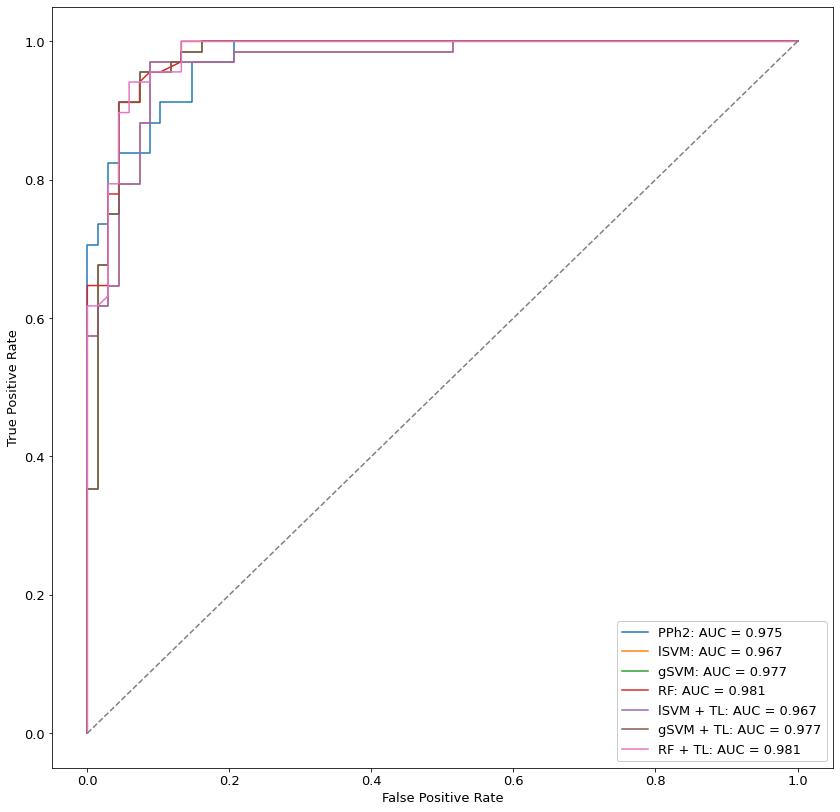

In [52]:
# ROC-curves for all classifiers related with P. sativum
roc_curves(tab_p, is_arab=False)

In [53]:
# Table with metrics for all classifiers related with P. sativum
mets_others(tab_p)

,Accuracy,FPR,FNR,AUC
PPh2,0.897,0.044,0.162,0.975
lSVM,0.934,0.088,0.044,0.967
gSVM,0.934,0.074,0.059,0.977
RF,0.934,0.088,0.044,0.981
lSVM + TL,0.934,0.088,0.044,0.967
gSVM + TL,0.934,0.074,0.059,0.977
RF + TL,0.941,0.059,0.059,0.981


# Resulting Table for C. arietinum 

In [54]:
# C. arietinum table
tab_c = cicer_table(subs_c, Xc, stdXc, pph2_pred_c, rf_wo)

# Save the table for a further analysis
tab_c.to_csv('freq_cicer/cicer_resulting_table.tsv', sep='\t')

In [55]:
tab_c

,protein,pos,wt,mt,Grantham,Sneath,Epstein,Miyata,Neighb1,Neighb2,...,Scaled_E_dist,Scaled_T_dist,Scaled_H_dist,Scaled_pph2_dScore,Scaled_pph2_Score1,Scaled_pph2_Nobs,Scaled_pph2_IdPmax,Scaled_pph2_IdQmin,pred_pph2,pred_best_clf
0,Ca_00009,230,M,I,10,22,0.03,0.29,84,84,...,0.799607,0.047684,0.478088,0.464835,0.725913,0.221946,0.230944,0.435854,0,1.0
1,Ca_00010,660,I,V,29,7,0.03,0.85,94,149,...,0.726916,0.806540,0.020916,0.378144,0.552660,0.011741,0.510569,0.956093,0,0.0
2,Ca_00021,541,T,S,58,12,0.03,0.89,89,58,...,0.540275,1.035422,0.031873,0.394994,0.555223,0.340709,0.380428,0.870743,0,0.0
3,Ca_00022,133,C,Y,194,34,0.25,2.38,215,169,...,0.512770,0.895095,0.032869,0.109158,0.015168,0.011063,0.607115,0.964339,0,0.0
4,Ca_00023,272,K,R,26,14,0.05,0.40,101,107,...,0.742633,0.666213,0.022908,0.425641,0.534288,0.028449,0.630005,0.922467,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3286,Ca_19754,460,P,H,77,36,0.81,2.15,110,76,...,0.715128,0.923706,0.000000,0.757387,0.777825,0.000226,0.183357,0.580649,1,1.0
3287,Ca_19754,183,D,N,23,14,0.00,0.65,108,172,...,0.683694,0.794278,0.026892,0.612821,0.819269,0.002258,0.328785,0.629193,1,1.0
3288,Ca_28106,173,P,H,77,36,0.81,2.15,98,0,...,0.611002,0.970027,0.013944,0.830281,0.868191,0.001580,0.178982,0.402517,1,1.0
3289,Ca_08709,603,H,Y,83,23,0.60,2.27,94,84,...,0.593320,0.125341,0.475100,0.662882,0.857295,0.008580,0.130408,0.593543,1,1.0
